Business Questions:
1. What are the factors that influence the time to resolve incident tickets?
2. Is there a difference in ticket resolution time between vendors?
3. Can customer satisfaction be related to the resolution time?

Approach:
The incident data was extracted from an EDL (3 month worth of data)
The incident resolution times cannot be directly related because the resolution time depend on the context of the ticket: Priority, Agreed SLA, ...
The first part of the analysis models predicts the incident resolution times based on the ticket context.
The second part of the analysis evaluates the factors of interest against the difference between actual and predicted resolution times.

In [1]:
# Import the applicable libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from scipy import stats
import seaborn as sns
%matplotlib inline

In [2]:
# Load the Incident data
df_org = pd.read_excel("Incidents.xlsx")

# Convert seconds to days
df_org["ttr_days"]=df_org["am_ttr"]/3600/24                 # Keep as an alternative: this is the time excluding time waiting for customer
df_org["ttr_days"]=df_org["global_ttr_seconds"]/3600/24

# Remove the columns that reflect time to resolve expressed in seconds
df_org.drop(columns=["am_ttr"], inplace=True)
df_org.drop(columns=["global_ttr_seconds"], inplace=True)

In [3]:
# Define the categorical values that can be considered as differentiators (causes) for the incident time to resolve
cat_vars = ["appl_tier","priority","contact_type","team","inc_close_code"]

# Classify the categorical values with less then 50 occurences as 'other'
df_org = df_org.apply(lambda x: x.mask(x.map(x.value_counts())<50, 'other') if x.name in cat_vars else x)

# Dummy the defined categorical variables
for var in  cat_vars:
    df_org = pd.concat([df_org, pd.get_dummies(df_org[var], prefix=var, prefix_sep='__', drop_first=True, dummy_na=False)], axis=1)

In [4]:
# Exclude the top 5% of time to resolve to avoid skewing the model
df = df_org[df_org["ttr_days"]<df_org["ttr_days"].quantile(0.95)]

# Retain the dummy categorical variables with '__' in their name as the X matrix
X_cols = [col for col in df.columns if '__' in col]
X = df[X_cols]

# Retain the time to resolve as the target variable
y = df['ttr_days']

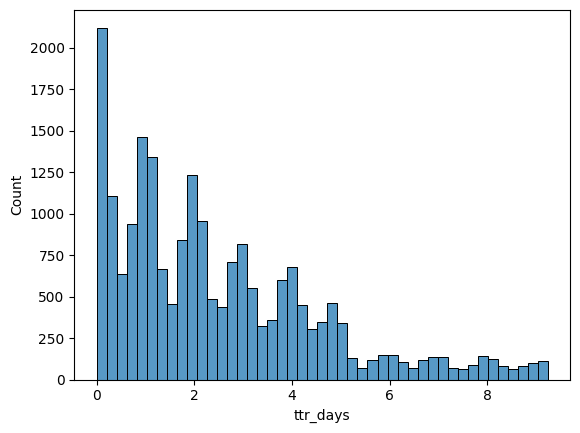

In [5]:
# Histogram of the time to resolve values (limited to those used as the input to the linear model)
sns.histplot(data=df,x="ttr_days")
plt.show()

The seasonality (daily) is due to reduced activity during nights

In [6]:
#Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Instantiate the linear model and fit to the train values
lm_model = LinearRegression(normalize=True)
lm_model.fit(X_train, y_train)

#Predict using linear model
y_test_preds = lm_model.predict(X_test)
y_train_preds = lm_model.predict(X_train)

#Score using linear model
r2_test = r2_score(y_test, y_test_preds)
r2_train = r2_score(y_train, y_train_preds)

print("Rsquared training data: {:.3f}.  Rsquared test data: {:.3f}".format(r2_train, r2_test))

Rsquared training data: 0.255.  Rsquared test data: 0.253


Rsquared results are almost the same for training and test data which indicates the model is fit for purpose
The purpose = check the influence of the other variables on the time to resolve.

Remark: including these other variables as part of the linear model leads to extreme overfitting

In [7]:
#Store the coefficients in an Excel file
def coef_weights(coefficients, X_train):
    '''
    INPUT:
    coefficients - the coefficients of the linear model 
    X_train - the training data, so the column names can be used
    OUTPUT:
    coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)
    
    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient.
    '''
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs'] = lm_model.coef_
    coefs_df = coefs_df.sort_values('coefs', ascending=False)
    return coefs_df

#Use the function
coef_df = coef_weights(lm_model.coef_, X_train)

#Export the coefficients to Excel
coef_df.to_excel("IncidentDuration_coef.xlsx")

coef_df

,est_int,coefs
3,priority__Priority 4,1.603126
1,appl_tier__Iron,1.582030
8,contact_type__self-service,1.042071
10,team__Specialist,0.699585
6,contact_type__other,0.513311
13,inc_close_code__Information Provided / Training,0.328495
9,contact_type__walk-in,0.243166
7,contact_type__phone,0.209895
11,inc_close_code__Data Correction,0.171359
5,contact_type__chat,0.143556


The coefficients match with the expected behavior.

In [8]:
#Calculate the predicted time to resolve by applying the model to the original dataset
df_org["pred"] = lm_model.predict(df_org[X_cols])

#Calculate the difference between the actual and predicted time to resolve
df_org["diff"] = df_org["ttr_days"]-df_org["pred"]

0.004440067931043209


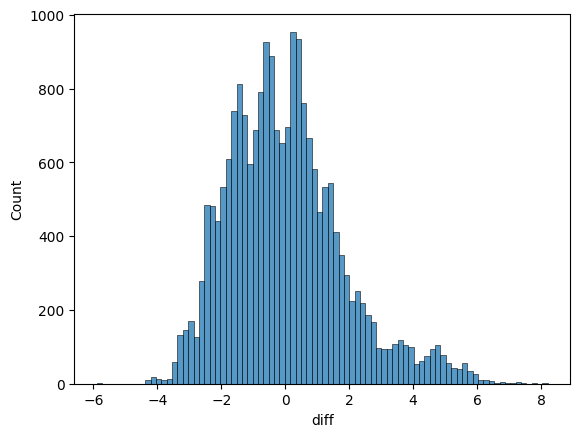

In [9]:
#Check the distribution of the calculated diff values through a histogram (centered around 0)
#Eliminate the outlier values since we are interested in the normal process behavior
df = df_org[df_org["ttr_days"]<df_org["ttr_days"].quantile(0.95)]
print(df["diff"].mean())
sns.histplot(data=df,x="diff")
plt.show()

In [10]:
# Determine the columns for which the statistics are to be calculated
# - Eliminate the dummy columns
# - Eliminate the target variables
# - Eliminate the variables that were used as input for the linear model
T_cols = [col for col in df.columns if '__' not in col]
T_cols = list(set(T_cols)-set(cat_vars)-set(["ttr_days","pred","diff"]))

In [11]:
# Create a new dataframe to collect the statistics for every Variable-Value combination
# Statistic: 1 Sample Ttest to check if mean is greater than 0
# Leave out Variable-Value with fewer than 25 rows

df_col_values_analysis = pd.DataFrame(columns=["Variable","Value","Count","Mean","Ttest","p_i","p_d"])

for col in T_cols:
    for value in df[col].unique():        
        if df[df[col]==value]["diff"].shape[0]>25:
            t_i, p_i =  stats.ttest_1samp(df[df[col]==value]["diff"],popmean=0,alternative='greater')
            t_d, p_d =  stats.ttest_1samp(df[df[col]==value]["diff"],popmean=0,alternative='less')
            new_row = {"Variable":col, "Value":value, "Count":df[df[col]==value].shape[0],"Mean": df[df[col]==value]["diff"].mean(),
                "Ttest": t_i,"p_i": p_i, "p_d": p_d}
            df_col_values_analysis = df_col_values_analysis.append(new_row, ignore_index=True)

In [13]:
# Store the statistics sorted by the calculated p value in 2 separate sheet:
# - Sheet "Increases"
# - Sheet "Decreases ""

with pd.ExcelWriter("Factors influencing TTR.xlsx") as writer:
    df_col_values_analysis.sort_values(by=["p_i","Mean"], ascending=[True,True],inplace=True)
    df_col_values_analysis.to_excel(writer,sheet_name="Factors with increased TTR.xlsx")
    df_col_values_analysis.sort_values(by=["p_d","Mean"], ascending=[True,False], inplace=True)
    df_col_values_analysis.to_excel(writer,sheet_name="Factors with decreased TTR.xlsx")

The 'Breached' tickets are 'by defintion' those that have taken more that the agreed SLA time.
So it is logical that these appear at the top of the list.

<AxesSubplot:xlabel='assignment_group_company', ylabel='diff'>

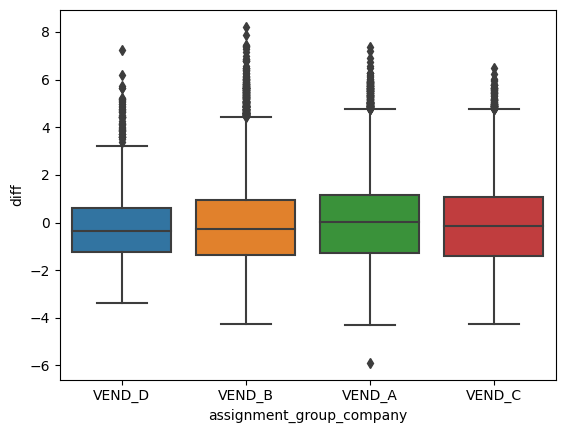

In [ ]:
# Boxplot to depict the difference in resolution time for 4 different vendors
sns.boxplot(data=df,x="assignment_group_company", y="diff")

In [ ]:
df_col_values_analysis[df_col_values_analysis["Variable"]=="assignment_group_company"]

,Variable,Value,Count,Mean,Ttest,p_i,p_d
221,assignment_group_company,VEND_D,2400,-0.219931,-7.850855,1.000000,3.087831e-15
222,assignment_group_company,VEND_B,7449,-0.021105,-0.976040,0.835462,1.645381e-01
224,assignment_group_company,VEND_C,3844,0.023617,0.784313,0.216452,7.835477e-01
223,assignment_group_company,VEND_A,7059,0.097237,4.402973,0.000005,9.999946e-01


Vendor D shows and decreased TTR of 5 hours
Vendor D has automated the assignment of tickets to their staff based on an availability matrix and tickets already assigned.
This may explain the better performance.

Vendor A shows and increased TTR of 2 hours.

<AxesSubplot:xlabel='csat_score', ylabel='diff'>

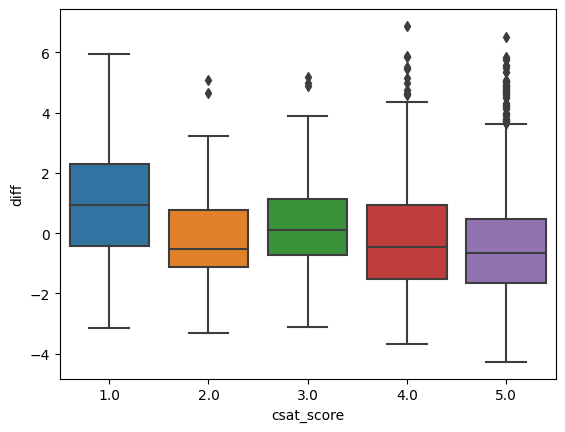

In [ ]:
# Boxplot to depict the relation between satisfaction and resolution time
# 1 = Low Satistfaction
# 5 = High Satisfaction
sns.boxplot(data=df,x="csat_score", y="diff")

In [ ]:
df_col_values_analysis[df_col_values_analysis["Variable"]=="csat_score"]

,Variable,Value,Count,Mean,Ttest,p_i,p_d
228,csat_score,5.0,1299,-0.417347,-8.532256,1.000000,1.972685e-17
230,csat_score,4.0,277,-0.114177,-0.991278,0.838791,1.612091e-01
232,csat_score,2.0,29,-0.154406,-0.405646,0.655957,3.440429e-01
229,csat_score,3.0,69,0.238393,1.101173,0.137352,8.626480e-01
231,csat_score,1.0,78,0.948523,4.047071,0.000061,9.999388e-01


Increased resolution times clearly lead to lower customer satisfaction.

<AxesSubplot:xlabel='reassignment_count', ylabel='diff'>

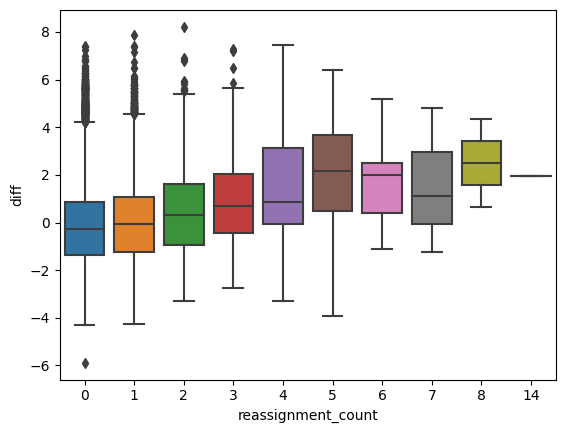

In [ ]:
# Boxplot to depict the effect of ticket reassignment (multiple groups and/or agents working sequentially on the ticket)
sns.boxplot(data=df,x="reassignment_count", y="diff")

In [ ]:
df_col_values_analysis[df_col_values_analysis["Variable"]=="reassignment_count"]

,Variable,Value,Count,Mean,Ttest,p_i,p_d
215,reassignment_count,0,14065,-0.069939,-4.599299,9.999979e-01,0.000002
216,reassignment_count,1,5557,0.046502,1.977665,2.400794e-02,0.975992
220,reassignment_count,5,33,2.109263,5.008835,9.683948e-06,0.999990
219,reassignment_count,4,69,1.439416,5.046470,1.790958e-06,0.999998
218,reassignment_count,2,794,0.491155,6.987910,2.958726e-12,1.000000
217,reassignment_count,3,217,1.051160,7.475684,9.475137e-13,1.000000


Ticket reassignments between groups and support staff members increase the resolution time.

<AxesSubplot:xlabel='reopened_flag', ylabel='diff'>

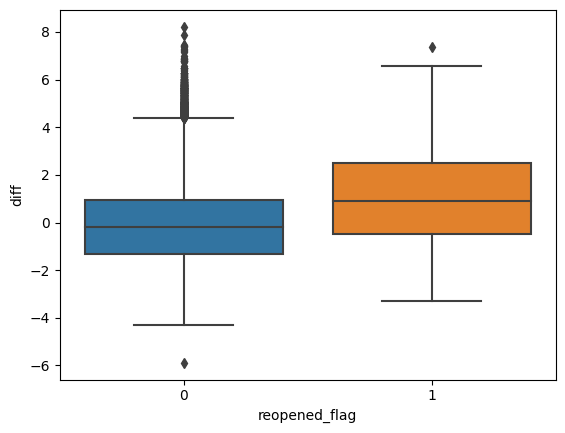

In [ ]:
# Boxplot to depict the effect of reopening a resolved ticket by a user
sns.boxplot(data=df,x="reopened_flag", y="diff")

In [ ]:
df_col_values_analysis[df_col_values_analysis["Variable"]=="reopened_flag"]

,Variable,Value,Count,Mean,Ttest,p_i,p_d
391,reopened_flag,0,20379,-0.015381,-1.218390,8.884550e-01,0.111545
392,reopened_flag,1,373,1.087383,9.795009,1.319106e-20,1.000000


Tickets that are reopened by the users have a longer resolution time.
